In [1]:
%matplotlib inline

import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from cselect import color as cs
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../samples')
from mvpose.data import shelf
from time import time

root = Settings['data_root']
root = join(root, 'pak')
tmp = Settings['tmp']

import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.settings import get_settings
from paf_loader import Loader
from mvpose.evaluation import pcp

# =====================================
params = get_settings(
    scale_to_mm=1000,
    ms_radius=50,
    ms_between_distance=50,
    gp_max_radius=150
)
loader = Loader()
# =====================================

import mvpose.data.skeleton_augmentation as ska
model_path = '../data/model_poseprediction.h5'
gen = ska.LimbGenerator(model_path, params.scale_to_mm)

def proper_pcp_calc(Y, Humans):
    alpha = 0.5
    L_Arms = []
    U_Arms = []
    L_Legs = []
    U_Legs = []
    GTIDs = []
  
    for gtid, gt in enumerate(Y):
        if gt is None:
            continue
        
        larms = 0
        uarms = 0
        llegs = 0
        ulegs = 0
        avg = 0
        for d in Humans:
            r = pcp.evaluate(gt, d, alpha)
            larms_ = r.lower_arms
            uarms_ = r.upper_arms
            ulegs_ = r.upper_legs
            llegs_ = r.lower_legs
            avg_ = (larms_ + uarms_ + ulegs_ + llegs_) / 4
            if avg_ > avg:
                avg = avg_
                larms = larms_
                uarms = uarms_
                llegs = llegs_
                ulegs = ulegs_
        
        L_Arms.append(larms)
        U_Arms.append(uarms)
        L_Legs.append(llegs)
        U_Legs.append(ulegs)
        GTIDs.append(gtid)
    
    return L_Arms, U_Arms, L_Legs, U_Legs, GTIDs
    
    
def generate_pcp_score(frame):
    global Settings, params
    
    Im, Y, Calib = shelf.get(root, frame)
    heatmaps, pafs = loader.load_confidence_map_and_paf(
        'shelf', Im, frame, dir=Settings['tmp'])
    detections = pose.estimate(Calib, heatmaps, pafs, 
                               settings=params, debug=False)

    # ohne PC
    Humans = kth.transform3d_from_mscoco(detections)
    L_Arms, U_Arms, L_Legs, U_Legs, GTIDs = proper_pcp_calc(Y, Humans)
    Ohne = (L_Arms, U_Arms, L_Legs, U_Legs, GTIDs)
    
    # mit PC
    detections = gen.apply(detections)
    Humans = kth.transform3d_from_mscoco(detections)
    L_Arms2, U_Arms2, L_Legs2, U_Legs2, GTIDs2 = proper_pcp_calc(Y, Humans)
    Mit = (L_Arms2, U_Arms2, L_Legs2, U_Legs2, GTIDs2)
    # --

    return Ohne, Mit

# =====================================

valid_frames = list(range(300, 600))
#valid_frames = list(range(300, 302))
PER_GTID = {}
PER_GTID_PC = {}
# FRAMES = []
# AVG = []


def build(per_gtid, obj):
    L_Arms, U_Arms, L_Legs, U_Legs, GTIDs = obj
    if len(L_Arms) > 0:
        for gtid, larms, uarms, llegs, ulegs in zip(
            GTIDs, L_Arms, U_Arms, L_Legs, U_Legs
        ):
            if not gtid in per_gtid:
                per_gtid[gtid] = {
                    'larms': [],
                    'uarms': [],
                    'llegs': [],
                    'ulegs': [],
                    'frame': []
                }
            per_gtid[gtid]['larms'].append(larms)
            per_gtid[gtid]['uarms'].append(uarms)
            per_gtid[gtid]['llegs'].append(llegs)
            per_gtid[gtid]['ulegs'].append(ulegs)
            per_gtid[gtid]['frame'].append(frame)

for frame in valid_frames:
    _start = time()
    Ohne, Mit =\
        generate_pcp_score(frame)
    _end = time()
    print('frame ' + str(frame) + ', elapsed:', _end - _start)
    build(PER_GTID, Ohne)
    build(PER_GTID_PC, Mit)
            
#             FRAMES.append(frame)
#             AVG.append((larms + uarms + llegs + ulegs)/4)
            
            

/home/tanke/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


frame 300, elapsed: 23.631158590316772
frame 301, elapsed: 15.520386219024658
frame 302, elapsed: 15.784710884094238
frame 303, elapsed: 15.370018720626831
frame 304, elapsed: 16.119820833206177
frame 305, elapsed: 16.089608907699585
frame 306, elapsed: 13.492302656173706
frame 307, elapsed: 13.57060194015503
frame 308, elapsed: 13.446810960769653
frame 309, elapsed: 13.379645347595215
frame 310, elapsed: 13.422721862792969
frame 311, elapsed: 13.482821702957153
frame 312, elapsed: 13.546359777450562
frame 313, elapsed: 13.431267023086548
frame 314, elapsed: 13.551171064376831
frame 315, elapsed: 15.074573516845703
frame 316, elapsed: 13.503189325332642
frame 317, elapsed: 13.426175594329834
frame 318, elapsed: 13.47172999382019
frame 319, elapsed: 13.517834186553955
frame 320, elapsed: 13.556117296218872
frame 321, elapsed: 13.498360395431519
frame 322, elapsed: 13.42266058921814
frame 323, elapsed: 13.381105661392212
frame 324, elapsed: 13.375936508178711
frame 325, elapsed: 13.34636

frame 511, elapsed: 13.685346841812134
frame 512, elapsed: 13.821146726608276
frame 513, elapsed: 14.006627082824707
frame 514, elapsed: 13.678691625595093
frame 515, elapsed: 15.44822907447815
frame 516, elapsed: 15.191873788833618
frame 517, elapsed: 17.72726607322693
frame 518, elapsed: 16.301023960113525
frame 519, elapsed: 13.819083452224731
frame 520, elapsed: 13.918088436126709
frame 521, elapsed: 28.238062858581543
frame 522, elapsed: 14.168520212173462
frame 523, elapsed: 16.06403422355652
frame 524, elapsed: 14.818994045257568
frame 525, elapsed: 15.901262521743774
frame 526, elapsed: 15.292867183685303
frame 527, elapsed: 16.42548632621765
frame 528, elapsed: 14.382180213928223
frame 529, elapsed: 14.961394309997559
frame 530, elapsed: 14.505990743637085
frame 531, elapsed: 14.618722438812256
frame 532, elapsed: 15.840862274169922
frame 533, elapsed: 14.90606427192688
frame 534, elapsed: 14.568365335464478
frame 535, elapsed: 14.757675170898438
frame 536, elapsed: 14.6573915

In [2]:
print("-----Without PC-----")
total_avg = []
for key, values in PER_GTID.items():
    print('actor ', key)
    print('\tuarms:', np.mean(values['uarms']))
    print('\tlarms:', np.mean(values['larms']))
    print('\tulegs:', np.mean(values['ulegs']))
    print('\tllegs:', np.mean(values['llegs']))
    avg = np.mean([
        np.mean(values['uarms']),
        np.mean(values['larms']),
        np.mean(values['ulegs']),
        np.mean(values['llegs'])
    ])
    total_avg.append(avg)
    print('\tavg:  ', avg)
print('\navg*:  ', np.mean(total_avg))

print("\n-----With PC-----")
total_avg = []
for key, values in PER_GTID_PC.items():
    print('actor ', key)
    print('\tuarms:', np.mean(values['uarms']))
    print('\tlarms:', np.mean(values['larms']))
    print('\tulegs:', np.mean(values['ulegs']))
    print('\tllegs:', np.mean(values['llegs']))
    avg = np.mean([
        np.mean(values['uarms']),
        np.mean(values['larms']),
        np.mean(values['ulegs']),
        np.mean(values['llegs'])
    ])
    total_avg.append(avg)
    print('\tavg:  ', avg)
print('\navg*:  ', np.mean(total_avg))

-----Without PC-----
actor  0
	uarms: 0.9175627240143369
	larms: 0.8530465949820788
	ulegs: 0.956989247311828
	llegs: 0.9551971326164874
	avg:   0.9206989247311828
actor  2
	uarms: 0.9440993788819876
	larms: 0.937888198757764
	ulegs: 0.9751552795031055
	llegs: 0.9658385093167702
	avg:   0.9557453416149069
actor  1
	uarms: 0.7567567567567568
	larms: 0.35135135135135137
	ulegs: 0.8108108108108109
	llegs: 0.8783783783783784
	avg:   0.6993243243243243

avg*:   0.8585895302234713

-----With PC-----
actor  0
	uarms: 0.9175627240143369
	larms: 0.8781362007168458
	ulegs: 0.9587813620071685
	llegs: 0.9605734767025089
	avg:   0.928763440860215
actor  2
	uarms: 0.9503105590062112
	larms: 0.9409937888198758
	ulegs: 0.9937888198757764
	llegs: 0.9937888198757764
	avg:   0.96972049689441
actor  1
	uarms: 0.7702702702702703
	larms: 0.4189189189189189
	ulegs: 0.8378378378378378
	llegs: 0.8918918918918919
	avg:   0.7297297297297298

avg*:   0.8760712224947849


In [5]:
# =====================================
# params = get_settings(
#     scale_to_mm=1000,
#     ms_radius=50,
#     ms_between_distance=50,
#     gp_max_radius=150
# )
# -----Without PC-----
# actor  0
# 	uarms: 0.9175627240143369
# 	larms: 0.8530465949820788
# 	ulegs: 0.956989247311828
# 	llegs: 0.9551971326164874
# 	avg:   0.9206989247311828
# actor  2
# 	uarms: 0.9440993788819876
# 	larms: 0.937888198757764
# 	ulegs: 0.9751552795031055
# 	llegs: 0.9658385093167702
# 	avg:   0.9557453416149069
# actor  1
# 	uarms: 0.7567567567567568
# 	larms: 0.35135135135135137
# 	ulegs: 0.8108108108108109
# 	llegs: 0.8783783783783784
# 	avg:   0.6993243243243243

# avg*:   0.8585895302234713

# -----With PC-----
# actor  0
# 	uarms: 0.9175627240143369
# 	larms: 0.8781362007168458
# 	ulegs: 0.9587813620071685
# 	llegs: 0.9605734767025089
# 	avg:   0.928763440860215
# actor  2
# 	uarms: 0.9503105590062112
# 	larms: 0.9409937888198758
# 	ulegs: 0.9937888198757764
# 	llegs: 0.9937888198757764
# 	avg:   0.96972049689441
# actor  1
# 	uarms: 0.7702702702702703
# 	larms: 0.4189189189189189
# 	ulegs: 0.8378378378378378
# 	llegs: 0.8918918918918919
# 	avg:   0.7297297297297298

# avg*:   0.8760712224947849


# =====================================
# params = get_settings(
#     scale_to_mm=1000,
#     ms_radius=50,
#     ms_between_distance=50,
#     gp_max_radius=130
# )
# -----Without PC-----
# actor  0
# 	uarms: 0.9050179211469535
# 	larms: 0.8351254480286738
# 	ulegs: 0.9390681003584229
# 	llegs: 0.9354838709677419
# 	avg:   0.9036738351254481
# actor  2
# 	uarms: 0.9440993788819876
# 	larms: 0.937888198757764
# 	ulegs: 0.9627329192546584
# 	llegs: 0.953416149068323
# 	avg:   0.9495341614906833
# actor  1
# 	uarms: 0.7027027027027027
# 	larms: 0.28378378378378377
# 	ulegs: 0.7432432432432432
# 	llegs: 0.8108108108108109
# 	avg:   0.6351351351351352

# avg*:   0.8294477105837554

# -----With PC-----
# actor  0
# 	uarms: 0.9086021505376344
# 	larms: 0.8620071684587813
# 	ulegs: 0.946236559139785
# 	llegs: 0.9408602150537635
# 	avg:   0.9144265232974911
# actor  2
# 	uarms: 0.9503105590062112
# 	larms: 0.9409937888198758
# 	ulegs: 0.984472049689441
# 	llegs: 0.9782608695652174
# 	avg:   0.9635093167701864
# actor  1
# 	uarms: 0.7162162162162162
# 	larms: 0.36486486486486486
# 	ulegs: 0.7702702702702703
# 	llegs: 0.8243243243243243
# 	avg:   0.6689189189189189

# avg*:   0.8489515863288655

# =====================================
# params = get_settings(
#     scale_to_mm=1000,
#     ms_radius=50,
#     ms_between_distance=50,
#     gp_max_radius=120
# )
# OHNE PC
# actor  0
# 	uarms: 0.9086021505376344
# 	larms: 0.8458781362007168
# 	ulegs: 0.9498207885304659
# 	llegs: 0.946236559139785
# 	avg:   0.9126344086021505
# actor  2
# 	uarms: 0.9440993788819876
# 	larms: 0.937888198757764
# 	ulegs: 0.968944099378882
# 	llegs: 0.9565217391304348
# 	avg:   0.9518633540372672
# actor  1
# 	uarms: 0.6891891891891891
# 	larms: 0.2702702702702703
# 	ulegs: 0.7837837837837838
# 	llegs: 0.8378378378378378
# 	avg:   0.6452702702702703

# avg*:   0.8365893443032294

# =====================================
# params = get_settings(
#     scale_to_mm=1000,
#     ms_radius=50,
#     ms_between_distance=50,
#     gp_max_radius=100
# )
# OHNE PC
# actor  0
# 	uarms: 0.910394265232975
# 	larms: 0.8422939068100358
# 	ulegs: 0.9480286738351255
# 	llegs: 0.931899641577061
# 	avg:   0.9081541218637993
# actor  2
# 	uarms: 0.9316770186335404
# 	larms: 0.9285714285714286
# 	ulegs: 0.9596273291925466
# 	llegs: 0.937888198757764
# 	avg:   0.93944099378882
# actor  1
# 	uarms: 0.7027027027027027
# 	larms: 0.25675675675675674
# 	ulegs: 0.7972972972972973
# 	llegs: 0.8378378378378378
# 	avg:   0.6486486486486486

# avg*:   0.8320812547670893

# =====================================
# params = get_settings(
#     scale_to_mm=1000,
#     ms_radius=50,
#     ms_between_distance=50,
#     gp_max_radius=150
# )
# OHNE PC
# actor  0
# 	uarms: 0.9175627240143369
# 	larms: 0.8530465949820788
# 	ulegs: 0.956989247311828
# 	llegs: 0.9551971326164874
# 	avg:   0.9206989247311828
# actor  2
# 	uarms: 0.9440993788819876
# 	larms: 0.937888198757764
# 	ulegs: 0.9751552795031055
# 	llegs: 0.9658385093167702
# 	avg:   0.9557453416149069
# actor  1
# 	uarms: 0.7567567567567568
# 	larms: 0.35135135135135137
# 	ulegs: 0.8108108108108109
# 	llegs: 0.8783783783783784
# 	avg:   0.6993243243243243

# avg*:   0.8585895302234713

NameError: name 'AVG' is not defined

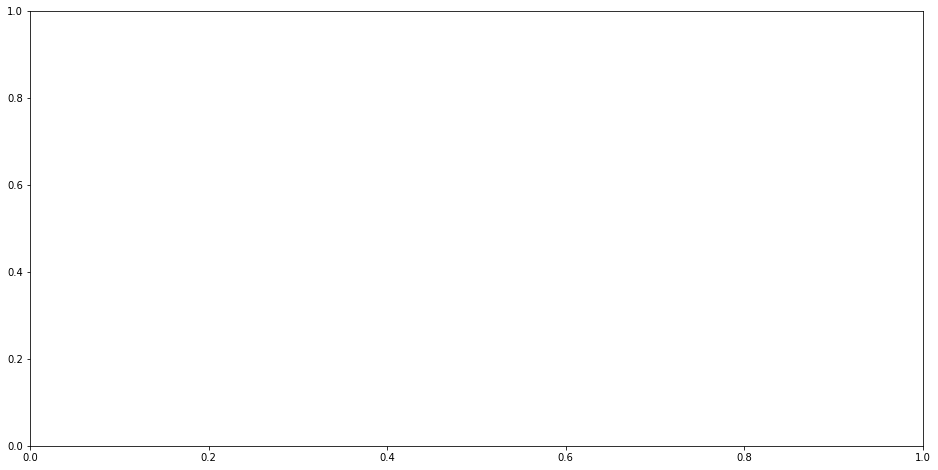

In [4]:
idx = 0

fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(111)
ax.plot(range(len(AVG)), AVG)
ax.set_ylim([0, 1.1])

ax.plot([idx, idx], [0, 1.5], alpha=0.5)
 
print("avg:\t", AVG[idx])
print('frame:\t', FRAMES[idx])
FRAME = FRAMES[idx]

plt.show()